In [2]:
import pandas as pd

df = pd.read_csv("/Users/ryanw/csv_files/cardio_train.csv", sep=";")

print(df.head())

   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  


In [3]:
features = df.drop(["cardio", "id"], axis=1)
outcome = df["cardio"]

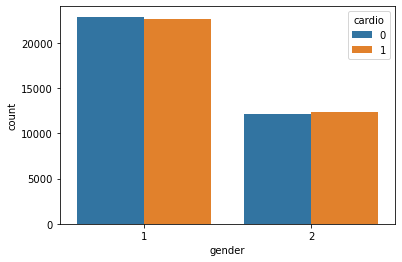

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

sns.countplot(data=df, x="gender", hue="cardio")
plt.show()

As we can see from the graph there are more observations of male patients in the data set and for both male and female patients the split between positive CVD and negative CVD is about even

<AxesSubplot:xlabel='smoke', ylabel='count'>

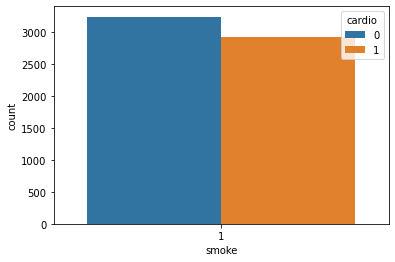

In [5]:
smoker_df = df[df["smoke"] == 1]

sns.countplot(data=smoker_df, x="smoke", hue="cardio")

In [6]:


percent_smokers_cvd = ((smoker_df["cardio"]).sum() / smoker_df["cardio"].count()).round(4)*100

print(f"percent of smokers with cvd: {percent_smokers_cvd}%")

percent of smokers with cvd: 47.48%


It appears that the split of smokers with cvd is slightly under 50/50

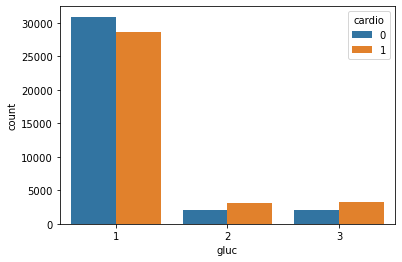

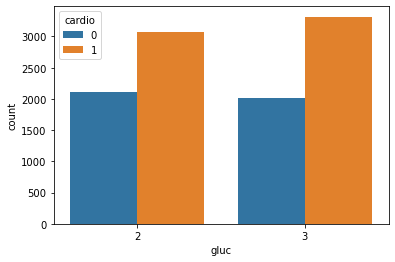

In [7]:
elevated_gluc = df[df["gluc"] > 1]

sns.countplot(data=df, x="gluc", hue="cardio")
plt.show()
sns.countplot(data=elevated_gluc, x="gluc", hue="cardio")
plt.show()

This graph shows that patients with normal glucose levels (represented by a 1) are less likely to have cvd while elevated glucose levels (represented by 2 for slightly elevated and 3 for severely elevated) are more likely.

In [73]:
slight_gluc = df[df["gluc"] == 2]
severe_gluc = df[df["gluc"] == 3]

slight_gluc_percent = (slight_gluc["cardio"].value_counts()[1] / (len(slight_gluc))).round(4)*100
severe_gluc_percent = (severe_gluc["cardio"].value_counts()[1] / (len(severe_gluc))).round(4)*100

print(f"percent of patients with cvd who have slighty elevated glucose: {slight_gluc_percent}%")
print(f"percent of patients with cvd who have severely elevated glucose: {severe_gluc_percent}%")

percent of patients with cvd who have slighty elevated glucose: 59.309999999999995%
percent of patients with cvd who have severely elevated glucose: 62.2%


This analysis shows that having an elevated glucose level increasses your chance of having cvd significantly

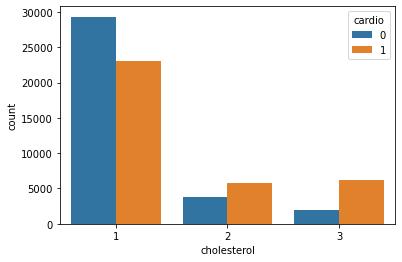

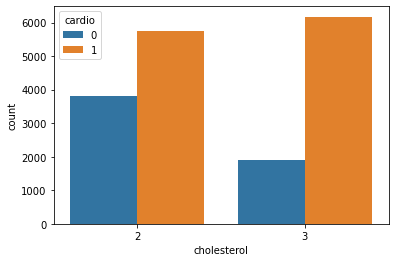

In [79]:
elevated_chol_df = df[df["cholesterol"] > 1]

sns.countplot(data=df, x="cholesterol", hue="cardio")
plt.show()
sns.countplot(data=elevated_chol_df, x="cholesterol", hue="cardio")
plt.show()

These two graphs show that increased cholesterol, especially severely increased, significantly increases your chance of cvd 

In [82]:
slight_elv_chol = df[df["cholesterol"] == 2]
severe_elv_chol = df[df["cholesterol"] == 3]

slight_chol_percent = (slight_elv_chol["cardio"].value_counts()[1] / len(slight_elv_chol)).round(4) * 100
severe_chol_percent = (severe_elv_chol["cardio"].value_counts()[1] / len(severe_elv_chol)).round(4) * 100

print(f"percent of patients with cvd and slightly elevated cholesterol: {slight_chol_percent}%")
print(f"percent of patients with cvd and severley elevated cholesterol: {severe_chol_percent}%")

percent of patients with cvd and slightly elevated cholesterol: 60.22%
percent of patients with cvd and severley elevated cholesterol: 76.53999999999999%


as we can see with this analysis you are much more likely to have cvd if your cholesterol level is elevated

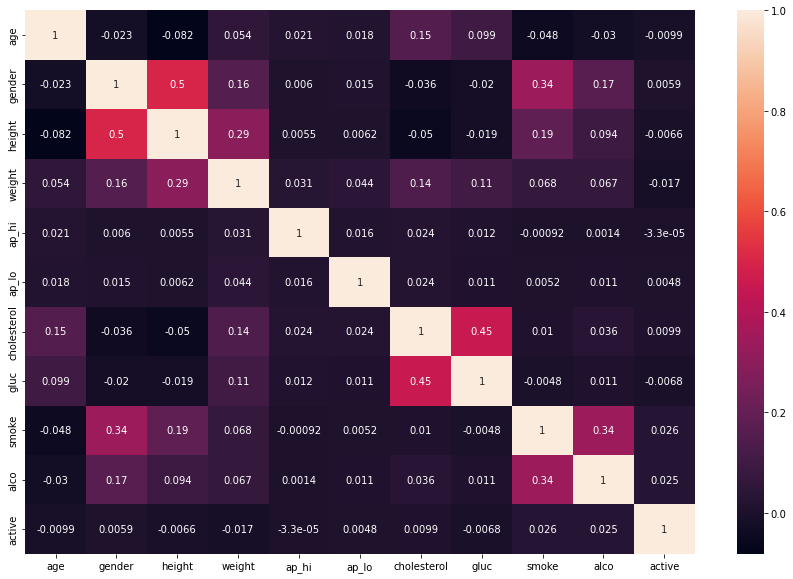

In [89]:
corr_matrix = features.corr()

plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, annot=True)
plt.show()

Looking at the correlation heatmap it appears that none of the features are correlated enough to warrant exclusion from a model with cholesterol and glucose and gender and height being the most correlated at .45 and .5 respectively

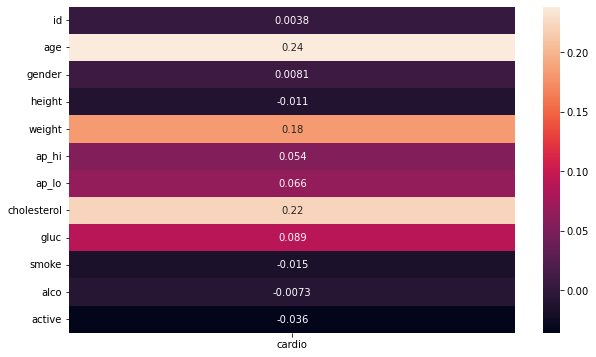

In [90]:
feature_outcome_corr = df.corr()

corr_target = feature_outcome_corr[["cardio"]].drop(labels=["cardio"])

plt.figure(figsize=(10, 6))

sns.heatmap(corr_target, annot=True)
plt.show()

looking at this heatmap showing the correlation between the features and the outcome we see that age and cholesterol are the top two correleated features when it comes to whether or not a patient has cvd while height and activity are among the lowest.

Weight looks like another big contributing factor so lets take a closer look at it. BMI is a better metric than weight alone so lets make another column for bmi

In [93]:
df["bmi"] = features["weight"] / ((features["height"] / 100)**2)

print(features["bmi"].head())

0    21.967120
1    34.927679
2    23.507805
3    28.710479
4    23.011177
Name: bmi, dtype: float64


now lets take a look at the correlation matrix again with bmi instead of weight

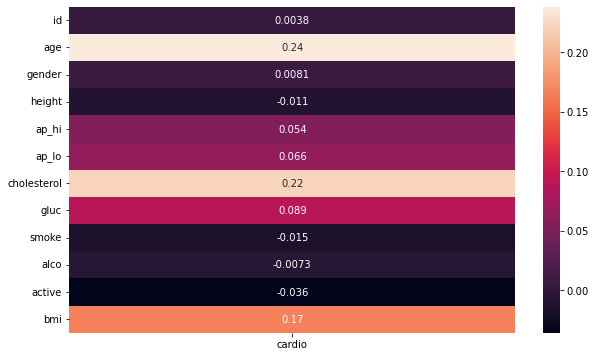

In [94]:
df_w_bmi = df.drop("weight", axis=1)
feature_outcome_corr = df_w_bmi.corr()

corr_target = feature_outcome_corr[["cardio"]].drop(labels=["cardio"])

plt.figure(figsize=(10, 6))

sns.heatmap(corr_target, annot=True)
plt.show()

now to create a model with the data, first we are going to scale the data since there is variation in the scales in the data

In [125]:
from sklearn.preprocessing import StandardScaler

feature_columns = features.columns

scaler = StandardScaler()

scaled_features = scaler.fit_transform(features)

print(scaled_features)

[[-0.43606151  1.36405487  0.44345206 ... -0.23838436  0.49416711
  -0.91757729]
 [ 0.30768633 -0.73310834 -1.01816804 ... -0.23838436  0.49416711
   1.21008057]
 [-0.24799666 -0.73310834  0.07804703 ... -0.23838436 -2.02360695
  -0.66465218]
 ...
 [-0.16328642  1.36405487  2.27047718 ...  4.19490608 -2.02360695
   0.62334178]
 [ 1.20058905 -0.73310834 -0.16555632 ... -0.23838436 -2.02360695
  -0.07506591]
 [ 0.43414373 -0.73310834  0.68705541 ... -0.23838436  0.49416711
  -0.4338885 ]]


In [117]:
scaled_features_df = pd.DataFrame()

scaled_features_df[feature_columns] = scaled_features

print(scaled_features_df.head())

        age    gender    height    weight     ap_hi     ap_lo  cholesterol  \
0 -0.436062  1.364055  0.443452 -0.847873 -0.122182 -0.088238    -0.539322   
1  0.307686 -0.733108 -1.018168  0.749831  0.072610 -0.035180     2.400793   
2 -0.247997 -0.733108  0.078047 -0.708942  0.007679 -0.141297     2.400793   
3 -0.748152  1.364055  0.565254  0.541435  0.137541  0.017879    -0.539322   
4 -0.808543 -0.733108 -1.018168 -1.264666 -0.187113 -0.194356    -0.539322   

      gluc     smoke      alco    active       bmi  
0 -0.39572 -0.310879 -0.238384  0.494167 -0.917577  
1 -0.39572 -0.310879 -0.238384  0.494167  1.210081  
2 -0.39572 -0.310879 -0.238384 -2.023607 -0.664652  
3 -0.39572 -0.310879 -0.238384  0.494167  0.189440  
4 -0.39572 -0.310879 -0.238384 -2.023607 -0.746181  


now that the data has been scaled we can split the data into training and testing groups

In [118]:
from sklearn.model_selection import train_test_split

feature_train, feature_test, outcome_train, outcome_test = train_test_split(scaled_features_df, outcome, test_size=0.2)

now we can fit and test our model

In [119]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()

log_reg.fit(feature_train, outcome_train)

print(log_reg.score(feature_test, outcome_test))

0.7257142857142858


this model barely crosses a significance threshold of .7 lets check to see if we can trim some non correlated features. many of the features have a correlation to the outcome of less than .1 so I will make a dataframe with just features above .05.

In [123]:
top_df = scaled_features_df[["bmi", "cholesterol", "age", "gluc", "ap_lo", "ap_hi"]]

feature_train, feature_test, outcome_train, outcome_test = train_test_split(top_df, outcome, test_size=0.2)

log_reg.fit(feature_train, outcome_train)

print(log_reg.score(feature_test, outcome_test))

0.7178571428571429


This models score is very similar to the previous models score with fewer features so we will keep this model 